# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import imageio
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.datasets import make_blobs
from IPython.display import HTML
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

In [0]:
np.random.seed(0)

# Data Generation and Preparation

In [4]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


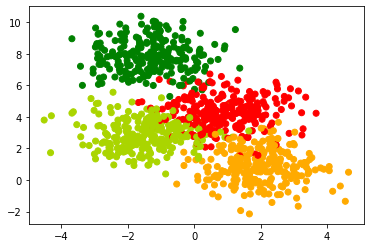

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

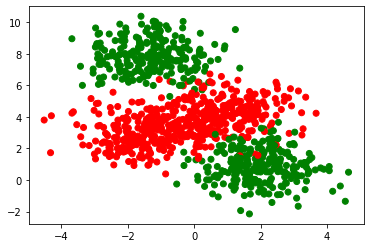

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [8]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [9]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


# Class for FFN with Algos

In [0]:
class VFFN:

    def __init__(self, W1, W2):
        self.params={}
        self.params["W1"] = W1.copy()
        self.params["W2"] = W2.copy()
        self.params["B1"] = np.zeros((1,2))
        self.params["B2"] = np.zeros((1,4))
        self.num_layers=2
        self.gradients={}
        self.update_params={}
        self.prev_update_params={}
        for i in range(1, self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
    
    def forward_activation(self, X):
        return 1.0/(1.0+np.exp(-X))

    def grad_activation(self, X):
        return X*(1-X)

    def softmax(self, X):
        exps = np.exp(X)
        return exps/np.sum(exps, axis=1).reshape(-1,1)
    
    def forward_pass(self, X, params=None):
        if params is None:
            params = self.params
        self.A1 = np.matmul(X, params["W1"]) + params["B1"]
        self.H1 = self.forward_activation(self.A1)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]
        self.H2 = self.softmax(self.A2)
        return self.H2

    def grad(self, X, Y, params=None):
        if params is None:
            params = self.params
        
        self.forward_pass(X,params)
        m = X.shape[0]
        self.gradients["dA2"] = self.H2-Y
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1,-1)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1,-1)
    
    def fit(self, X, Y, epochs=1, algo="GD", display_loss=False,
            eta=1, mini_batch_size=100, eps=1e-8,
            beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9):
        
        if display_loss:
            loss = {}
        for num_epochs in tqdm(range(epochs), total=epochs, unit='epoch'):
            m=X.shape[0]

            if algo=="GD":
                self.grad(X,Y)
                for i in range(1, self.num_layers+1):
                     self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                     self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)

            elif algo=="MiniBatch":
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(1,self.num_layers+1):
                        self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)

            elif algo=="Momentum":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]

            elif algo=="NAG":
                temp_params={}
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)] = self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
                self.grad(X,Y,temp_params)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
                self.prev_update_params = self.update_params 
            
            elif algo=="AdaGrad":
                self.grad(X,Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)

            elif algo=="RMSProp":
                self.grad(X,Y)
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] + (1-beta)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] + (1-beta)*((self.gradients["dB"+str(i)]/m)**2)
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)

            elif algo=="Adam":
                self.grad(X,Y)
                num_updates=0
                for i in range(1, self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
                    self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["W"+str(i)] -= (eta/np.sqrt(v_w_hat+eps))*m_w_hat

                    self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
                    self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["B"+str(i)] -= (eta/np.sqrt(v_b_hat+eps))*m_b_hat
            
            if display_loss:
                Y_pred = self.predict(X)
                loss[num_epochs] = log_loss(np.argmax(Y, axis=1), Y_pred)

        if display_loss:
            plt.plot(np.array(list(loss.values())).astype(np.float), '-o', markersize=5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

# Accuracy and Plot Function

In [0]:
def print_accuracy(show_plot=False):
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training Accuracy: ", round(accuracy_train,4))
    print("Validation Accuracy: ", round(accuracy_val,4))

    if show_plot is True:
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+0.1))
        plt.show()

# Results:

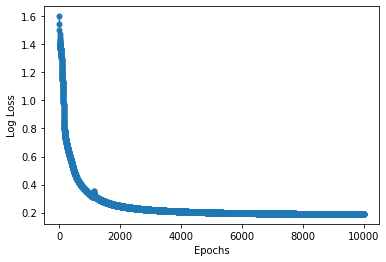

Training Accuracy:  0.9293
Validation Accuracy:  0.936


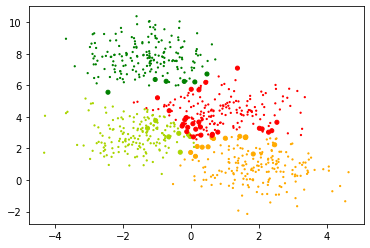

CPU times: user 16.1 s, sys: 192 ms, total: 16.3 s
Wall time: 16.4 s


In [12]:
%%time
model = VFFN(W1, W2)
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy(True)

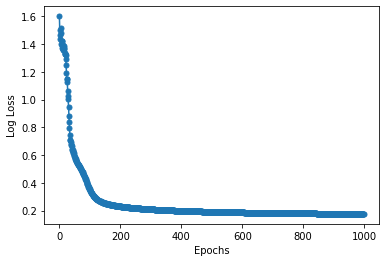

Training Accuracy:  0.9267
Validation Accuracy:  0.944


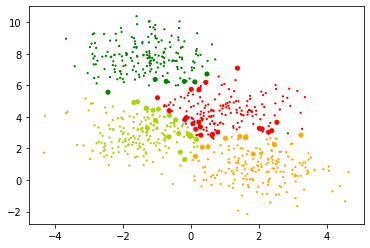

CPU times: user 2.03 s, sys: 114 ms, total: 2.14 s
Wall time: 2.07 s


In [13]:
%%time
model = VFFN(W1,W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy(True)

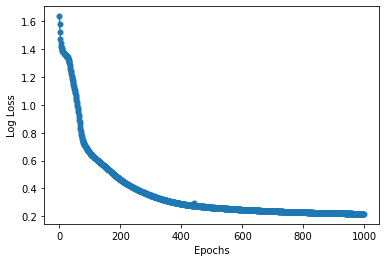

Training Accuracy:  0.9213
Validation Accuracy:  0.94


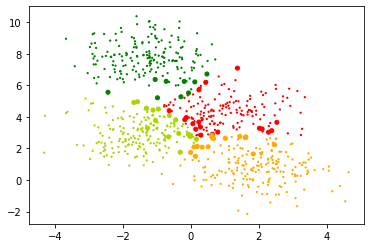

CPU times: user 2.01 s, sys: 123 ms, total: 2.13 s
Wall time: 2.06 s


In [14]:
%%time
model = VFFN(W1,W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy(True)

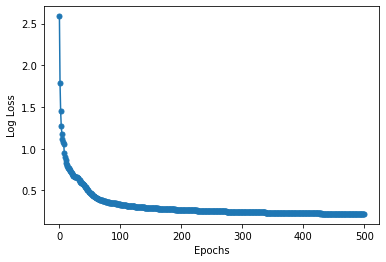

Training Accuracy:  0.912
Validation Accuracy:  0.936


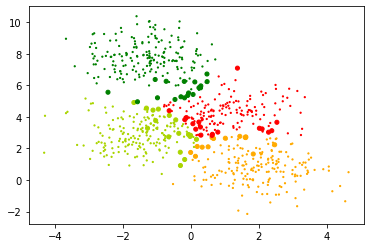

CPU times: user 1.22 s, sys: 112 ms, total: 1.33 s
Wall time: 1.24 s


In [15]:
%%time
model = VFFN(W1,W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy(True)

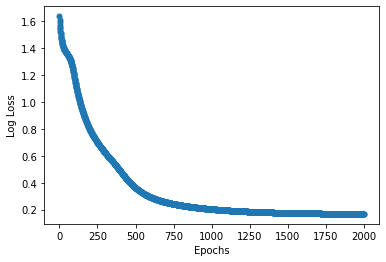

Training Accuracy:  0.9253
Validation Accuracy:  0.94


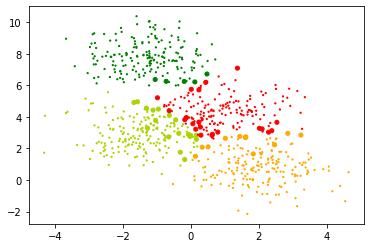

CPU times: user 3.7 s, sys: 138 ms, total: 3.84 s
Wall time: 3.81 s


In [16]:
%%time
model = VFFN(W1,W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy(True)

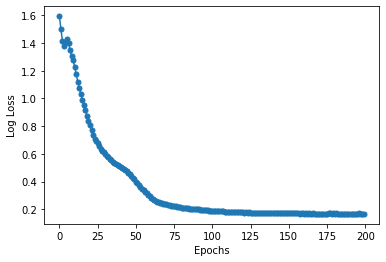

Training Accuracy:  0.9293
Validation Accuracy:  0.952


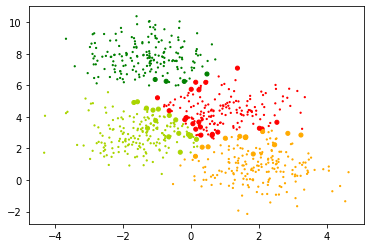

CPU times: user 739 ms, sys: 105 ms, total: 844 ms
Wall time: 761 ms


In [17]:
%%time
model = VFFN(W1,W2)
model.fit(X_train, y_OH_train, epochs=200, eta=0.1, algo="Adam", beta1=0.9, beta2=0.9, display_loss=True)
print_accuracy(True)